In [31]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

In [32]:
# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 50

# Path to dataset
IMAGE_DIR = "dataset/image"
MASK_DIR = "dataset/mask"


In [33]:
# Load images and masks
def load_data(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))  # Ensure correct order
    mask_files = sorted(os.listdir(mask_dir))

    count = 0

    for img_file, mask_file in zip(image_files, mask_files):
        if(count>=1000):
            break
        # Read and resize images
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, img_size) / 255.0  # Normalize

        # Read and resize masks
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Convert to binary (0 or 1)

        images.append(img)
        masks.append(mask)
        count+=1
    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(IMAGE_DIR, MASK_DIR)
print(f"Dataset loaded: {X.shape}, {Y.shape}")

Dataset loaded: (1000, 128, 128, 3), (1000, 128, 128, 1)


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Hyperparameters
START_FILTERS = 64  # Starting number of filters, all others are multiples of this
DROPOUT_RATE = 0.3  # Dropout rate to reduce overfitting
LEARNING_RATE = 1e-3  # Lower learning rate for stable convergence
BATCH_SIZE = 16
EPOCHS = 50

def unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), start_filters=START_FILTERS, dropout_rate=DROPOUT_RATE):
    inputs = Input(input_shape)

    # Encoder
    f = start_filters  # Base filter size
    c1 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    f *= 2
    c2 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    f *= 2
    c3 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    f *= 2
    c4 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    f *= 2
    c5 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(dropout_rate)(c5)
    c5 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    f //= 2
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(dropout_rate)(c6)
    c6 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    f //= 2
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(dropout_rate)(c7)
    c7 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    f //= 2
    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(dropout_rate)(c8)
    c8 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    f //= 2
    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(dropout_rate)(c9)
    c9 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Metrics
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

# Compile Model
model = unet()
def dice_loss(y_true, y_pred, smooth=1e-6):
    # Do not threshold y_pred; use it as is for gradient flow.
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coef = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice_coef


def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=dice_loss, metrics=[iou_metric, dice_metric])

# Train Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# Save Model
model.save("final-128.h5")


Epoch 1/50
50/50 [==============================] - 9s 163ms/step - loss: 0.3166 - iou_metric: 0.5326 - dice_metric: 0.6884 - val_loss: 0.5001 - val_iou_metric: 0.3325 - val_dice_metric: 0.4987
Epoch 2/50
50/50 [==============================] - 8s 159ms/step - loss: 0.1995 - iou_metric: 0.6706 - dice_metric: 0.8023 - val_loss: 0.5005 - val_iou_metric: 0.3322 - val_dice_metric: 0.4983
Epoch 3/50
50/50 [==============================] - 8s 160ms/step - loss: 0.1775 - iou_metric: 0.7010 - dice_metric: 0.8236 - val_loss: 0.4348 - val_iou_metric: 0.3932 - val_dice_metric: 0.5638
Epoch 4/50
50/50 [==============================] - 8s 160ms/step - loss: 0.1648 - iou_metric: 0.7190 - dice_metric: 0.8360 - val_loss: 0.2238 - val_iou_metric: 0.6344 - val_dice_metric: 0.7760
Epoch 5/50
50/50 [==============================] - 8s 161ms/step - loss: 0.1514 - iou_metric: 0.7387 - dice_metric: 0.8492 - val_loss: 0.2809 - val_iou_metric: 0.5636 - val_dice_metric: 0.7202
Epoch 6/50
50/50 [============

In [6]:
# model=tf.keras.models.load_model("ak.h5",custom_objects={'iou_metric':iou_metric,'dice_metric':dice_metric})

In [35]:
import numpy as np


def calculate_iou(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    # Handle edge case of empty masks
    if union == 0:
        return 1.0  # Both masks are empty, perfect match

    return intersection / union

def calculate_dice(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate dice coefficient: 2*|X∩Y|/(|X|+|Y|)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    # Handle edge case of empty masks
    if total == 0:
        return 1.0  # Both masks are empty, perfect match

    return 2 * intersection / total

# Predict on validation set
y_preds = model.predict(X)

# Compute IoU for each image
iou_scores = []
dice_scores = []
for i in range(len(Y)):
    iou = calculate_iou(Y[i], y_preds[i])
    dice = calculate_dice(Y[i], y_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"Image {i+1}: IoU = {iou:.4f}")
    print(f"Image {i+1}: Dice = {dice:.4f}")

# Compute Mean IoU
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"\nMean IoU on Validation Set: {mean_iou:.4f}")
print(f"\nMean Dice on Validation Set: {mean_dice:.4f}")

32/32 [==============================] - 3s 86ms/step
Image 1: IoU = 0.9520
Image 1: Dice = 0.9754
Image 2: IoU = 0.6576
Image 2: Dice = 0.7934
Image 3: IoU = 0.8599
Image 3: Dice = 0.9247
Image 4: IoU = 0.9196
Image 4: Dice = 0.9581
Image 5: IoU = 0.5713
Image 5: Dice = 0.7271
Image 6: IoU = 0.7195
Image 6: Dice = 0.8369
Image 7: IoU = 0.7273
Image 7: Dice = 0.8421
Image 8: IoU = 0.7034
Image 8: Dice = 0.8259
Image 9: IoU = 0.8747
Image 9: Dice = 0.9332
Image 10: IoU = 0.7219
Image 10: Dice = 0.8385
Image 11: IoU = 0.8951
Image 11: Dice = 0.9447
Image 12: IoU = 0.8335
Image 12: Dice = 0.9092
Image 13: IoU = 0.7150
Image 13: Dice = 0.8338
Image 14: IoU = 0.4071
Image 14: Dice = 0.5786
Image 15: IoU = 0.3633
Image 15: Dice = 0.5330
Image 16: IoU = 0.3096
Image 16: Dice = 0.4728
Image 17: IoU = 0.4346
Image 17: Dice = 0.6059
Image 18: IoU = 0.5624
Image 18: Dice = 0.7199
Image 19: IoU = 0.4413
Image 19: Dice = 0.6123
Image 20: IoU = 0.8703
Image 20: Dice = 0.9307
Image 21: IoU = 0.7975
I

In [36]:
import numpy as np


def calculate_iou(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    # Handle edge case of empty masks
    if union == 0:
        return 1.0  # Both masks are empty, perfect match

    return intersection / union

def calculate_dice(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate dice coefficient: 2*|X∩Y|/(|X|+|Y_val|)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    # Handle edge case of empty masks
    if total == 0:
        return 1.0  # Both masks are empty, perfect match

    return 2 * intersection / total

# Predict on validation set
y_preds = model.predict(X_val)

# Compute IoU for each image
iou_scores = []
dice_scores = []
for i in range(len(Y_val)):
    iou = calculate_iou(Y_val[i], y_preds[i])
    dice = calculate_dice(Y_val[i], y_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"Image {i+1}: IoU = {iou:.4f}")
    print(f"Image {i+1}: Dice = {dice:.4f}")

# Compute Mean IoU
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"\nMean IoU on Validation Set: {mean_iou:.4f}")
print(f"\nMean Dice on Validation Set: {mean_dice:.4f}")

7/7 [==============================] - 0s 79ms/step
Image 1: IoU = 0.8568
Image 1: Dice = 0.9229
Image 2: IoU = 0.8991
Image 2: Dice = 0.9469
Image 3: IoU = 0.9320
Image 3: Dice = 0.9648
Image 4: IoU = 0.8504
Image 4: Dice = 0.9191
Image 5: IoU = 0.7755
Image 5: Dice = 0.8735
Image 6: IoU = 0.8446
Image 6: Dice = 0.9157
Image 7: IoU = 0.9062
Image 7: Dice = 0.9508
Image 8: IoU = 0.9012
Image 8: Dice = 0.9480
Image 9: IoU = 0.7723
Image 9: Dice = 0.8715
Image 10: IoU = 0.7989
Image 10: Dice = 0.8882
Image 11: IoU = 0.6781
Image 11: Dice = 0.8082
Image 12: IoU = 0.9297
Image 12: Dice = 0.9636
Image 13: IoU = 0.7970
Image 13: Dice = 0.8871
Image 14: IoU = 0.6286
Image 14: Dice = 0.7720
Image 15: IoU = 0.6011
Image 15: Dice = 0.7508
Image 16: IoU = 0.7157
Image 16: Dice = 0.8343
Image 17: IoU = 0.7383
Image 17: Dice = 0.8495
Image 18: IoU = 0.3622
Image 18: Dice = 0.5318
Image 19: IoU = 0.8016
Image 19: Dice = 0.8899
Image 20: IoU = 0.8713
Image 20: Dice = 0.9312
Image 21: IoU = 0.8815
Ima

1/1 [==============================] - 0s 62ms/step


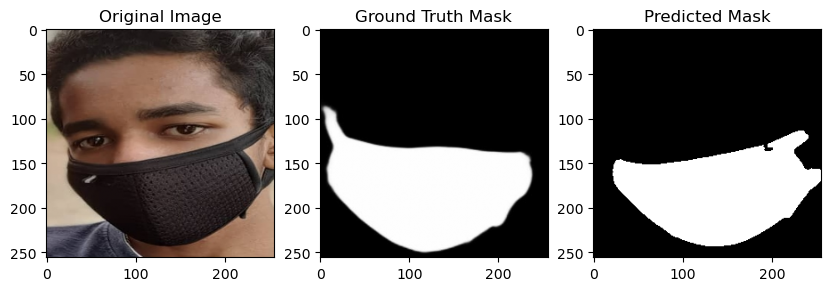

In [11]:
# Evaluate Model
def predict_sample(model, X_val, Y_val, index=10):
    pred_mask = model.predict(np.expand_dims(X_val[index], axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Thresholding

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[index])
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[index].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.show()

# Test model on a sample image
predict_sample(model, X_val, Y_val)